In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random

from pyrqa.time_series import TimeSeries, EmbeddedSeries
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation
from pyrqa.metric import EuclideanMetric, MaximumMetric 
from pyrqa.analysis_type import Classic

from pyunicorn.timeseries import RecurrencePlot

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
from matplotlib.ticker import MultipleLocator, MaxNLocator

import warnings
# Suppress specific warnings
# warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')
# warnings.filterwarnings('ignore', category=UserWarning, module='IPython')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score




In [2]:
df = pd.read_csv('1ES_binned_lc.csv')
pred_df = pd.read_csv('1ES_pred_DHO_lc.csv')

lc, dho_lc = df['scaled lumin'].values, pred_df['lumin'].values

rp = RecurrencePlot(df['scaled lumin'].values, metric='supremum', silence_level=2, local_recurrence_rate=0.1, tau=9, dim=5)
pred_rp = RecurrencePlot(pred_df['lumin'].values, metric='supremum', silence_level=2, local_recurrence_rate=0.1, tau=8, dim=6)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


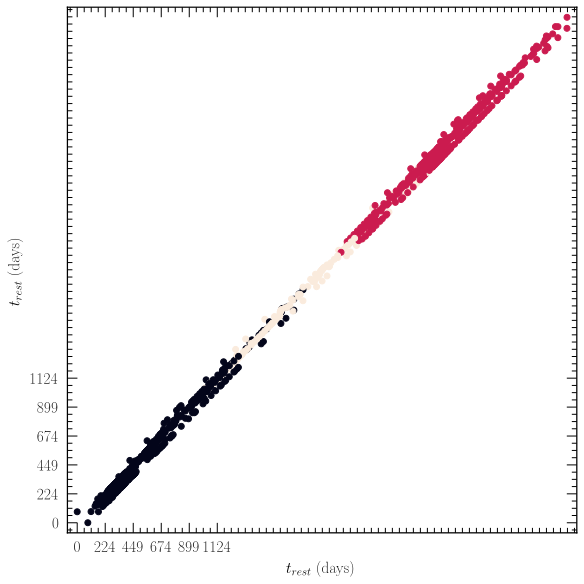

In [3]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=3) 
data = rp._distance_matrix
clusters = kmeans.fit_predict(data)

# cmap = sns.color_palette("rocket", as_cmap=True)
cmap = sns.color_palette("rocket", as_cmap=True)
# Plotting the results
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(data[:, 0], data[:, 1], c=clusters, cmap=cmap)
ax.set_xlabel(r'$t_{rest}$ (days)')
ax.set_ylabel(r'$t_{rest}$ (days)')


time_series_length = 1124  # length of time series
tick_interval = 200 

# Set up major ticks at fixed intervals
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Generate tick labels mapping the [0,1] axis limits to the original time points
ticks_x = np.linspace(0, 1, num=time_series_length//tick_interval + 1)
labels_x = [str(int(label)) for label in np.linspace(0, time_series_length, num=len(ticks_x))]

ticks_y = np.linspace(0, 1, num=time_series_length//tick_interval + 1)
labels_y = [str(int(label)) for label in np.linspace(0, time_series_length, num=len(ticks_y))]

ax.set_xticks(ticks_x)
ax.set_xticklabels(labels_x)
ax.set_yticks(ticks_y)
ax.set_yticklabels(labels_y)

# plt.title('KMeans Clustering of the Embedded Recurrence Plot')
plt.savefig('../plots/1ES_embedded_RP_kmeans_3clusters.pdf', bbox_inches='tight')
plt.show()

Methods for determining the optimal number of clusters for data if unknown

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

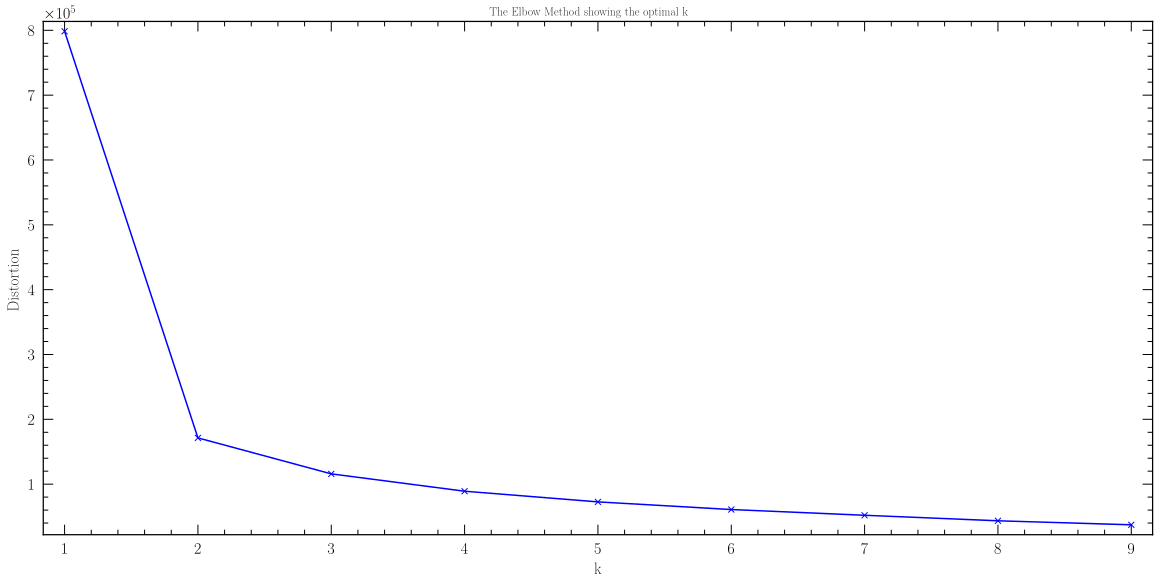

In [8]:
# Elbow Method

distortions = []
K = range(1, 10)  # range to consider
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

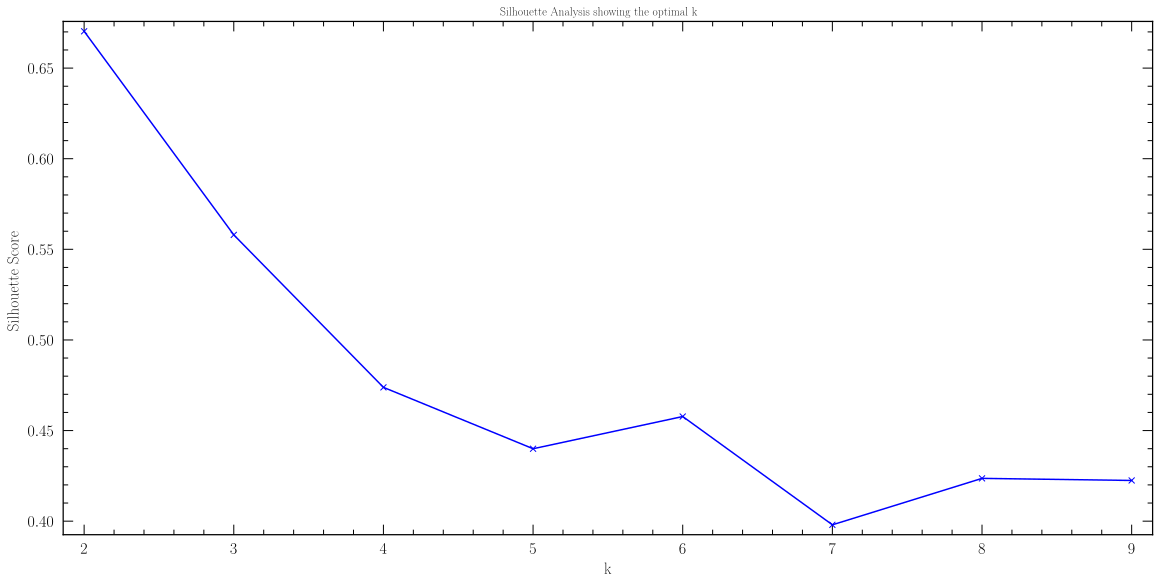

In [9]:
# silhouette analysis

silhouette_scores = []
K = range(2, 10)  # silhouette analysis requires at least 2 clusters
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    preds = kmeanModel.fit_predict(data)
    score = silhouette_score(data, preds)
    silhouette_scores.append(score)

plt.figure(figsize=(16,8))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis showing the optimal k')
plt.show()


In [ ]:

def distribute_evenly(number_of_changes, time_step_distance):
    # This function needs to be defined. For now, assume it distributes changes evenly
    return [number_of_changes // time_step_distance] * time_step_distance

def generate_dyn_graph(m, graph_steps, time_step_distance):
    graph_list = []
    last_graph = nx.gnm_random_graph(m, graph_steps.pop(0))
    graph_list.append(last_graph)

    while graph_steps:
        next_graph = nx.gnm_random_graph(m, graph_steps.pop(0))
        edges_to_add, edges_to_remove = differences(last_graph, next_graph)
        number_of_changes = len(edges_to_add) + len(edges_to_remove)
        changes_per_time_step = distribute_evenly(number_of_changes, time_step_distance)

        for time_step in range(1, time_step_distance + 1):
            current_graph = graph_list[-1].copy()
            for change in range(changes_per_time_step[time_step - 1]):
                choice = random.choice(['add', 'remove'])
                if choice == 'add':
                    add_random_edge_to_graph(current_graph, edges_to_add)
                else:
                    remove_random_edge_from_graph(current_graph, edges_to_remove)
            graph_list.append(current_graph)

        last_graph = next_graph

    return graph_list

# Helper functions that need to be defined:
# differences: Identify edges to add and remove when evolving from last_graph to next_graph.
# add_random_edge_to_graph: Add an edge to the graph from the edges_to_add list.
# remove_random_edge_from_graph: Remove an edge from the graph from the edges_to_remove list.

def generate_graph(m, graph_steps):
    cluster_list = []

    # Generate initial clusters
    for cluster_size in graph_steps:
        cluster_list.append(nx.barabasi_albert_graph(cluster_size, m))

    # Merge clusters into a single graph
    while len(cluster_list) > 1:
        merge_graph1 = cluster_list.pop(0)
        merge_graph2 = cluster_list.pop(0)
        current_graph = nx.disjoint_union(merge_graph1, merge_graph2)  # This performs the merge
        cluster_list.append(current_graph)

    return cluster_list[0] if cluster_list else nx.Graph()


In [ ]:
# color code the RP by node degree colors plotted above
degrees = dict(G.degree())
values = list(degrees.values())
color_map = [value for value in values]
size_map = [value * 0.5 for value in values] 

cmap = sns.color_palette("rocket", as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(values), vmax=max(values)))
sm.set_array([])

max_degree = max(degrees.values())

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3) # number of clusters
clusters = kmeans.fit_predict(rp.recurrence_matrix())


In [ ]:
# Get the unique cluster labels and create a mapping to colors
unique_clusters = np.unique(clusters)
color_mapping = plt.cm.get_cmap('cool', len(unique_clusters))

# Create an array to store RGB colors for each cluster label
cluster_colors_rgb = color_mapping(unique_clusters)

# Map the cluster labels to their corresponding colors
cluster_label_to_color = dict(zip(unique_clusters, cluster_colors_rgb))

recurrence_matrix = rp.recurrence_matrix()

# Create a color matrix corresponding to the recurrence_matrix
color_matrix = np.zeros((*recurrence_matrix.shape, 4))  # Initialize a color matrix with 4 channels (RGBA)

for i in range(recurrence_matrix.shape[0]):
    for j in range(recurrence_matrix.shape[1]):
        if recurrence_matrix[i, j] == 1:
            # Assign the color based on the cluster label
            color_matrix[i, j] = cluster_label_to_color[clusters[i]]

# Now plot the recurrence matrix colored by cluster
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(color_matrix, aspect='auto', interpolation='none', origin='lower', cmap=cmap)
ax.tick_params(labelbottom=True, labelleft=True, bottom=False, right=False, top=False, left=False)
plt.show()